In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src/")
import jax.numpy as jnp
import jax
import jax.tree_util as jtu
import genjax
from genjax import gen, Target, smc
from genjax import ChoiceMapBuilder as C
from config import *
from IPython.display import HTML
genjax.pretty()

In [3]:
from maskcombinator_model import multifirefly_model
from utils import *
multi_model_jit = jax.jit(multifirefly_model.importance)

In [135]:
key = jax.random.PRNGKey(90182)
key, subkey = jax.random.split(key)
max_fireflies = jnp.arange(1, 5)

constraint = C["n_fireflies"].set(2)
time_mask = jnp.arange(TIME_STEPS) < TIME_STEPS # Number of time steps to simulate
tr, w = multi_model_jit(subkey, constraint, (max_fireflies, time_mask,))

chm = tr.get_sample()
print(chm)

Static({'steps': Indexed(c=Static({'dynamics': Indexed(c=Static({'blink': Choice(v=Mask(value=<jax.Array int32(10, 4) [≥0, ≤1] zero:21 nonzero:19>, flag=<jax.Array bool(10, 4) true:20 false:20>)), 'vx': Choice(v=Mask(value=<jax.Array float32(10, 4) ≈0.22 ±0.78 [≥-1.3, ≤1.4] nonzero:40>, flag=<jax.Array bool(10, 4) true:20 false:20>)), 'vy': Choice(v=Mask(value=<jax.Array float32(10, 4) ≈0.33 ±0.89 [≥-1.8, ≤1.7] nonzero:40>, flag=<jax.Array bool(10, 4) true:20 false:20>)), 'x': Choice(v=Mask(value=<jax.Array float32(10, 4) ≈1.8e+01 ±9.0 [≥0.64, ≤2.9e+01] nonzero:40>, flag=<jax.Array bool(10, 4) true:20 false:20>)), 'y': Choice(v=Mask(value=<jax.Array float32(10, 4) ≈2.3e+01 ±6.4 [≥1.2e+01, ≤3.2e+01] nonzero:40>, flag=<jax.Array bool(10, 4) true:20 false:20>))}), addr=None), 'observations': {'pixels': Choice(v=Mask(value=<jax.Array float32(10, 32, 32) ≈0.014 ±0.058 [≥1.2e-06, ≤1.0] nonzero:10_240>, flag=<jax.Array bool(10,) true:10>))}}), addr=None), 'init': Indexed(c=Static({'blink_rate

In [136]:
anim = animate(list(chm["steps", :, "observations", "pixels"].value), 20)
HTML(anim.to_jshtml())

Try running SIR with 10,000 samples

In [137]:
importance = jax.jit(multifirefly_model.importance)
pixels = chm["steps", 4, "observations", "pixels"]
address = ["steps", 0, "observations", "pixels"]

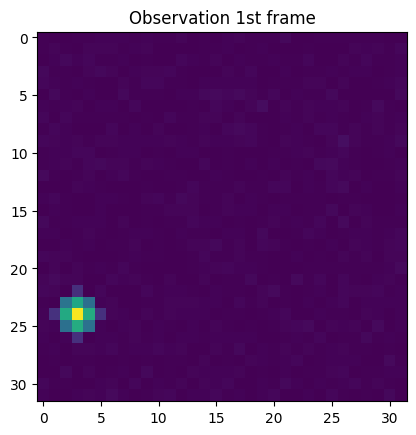

Weight (1 firefly): -26232.8671875,     
Weight (2 fireflies): -11468.0009765625,     
Weight (4 fireflies): -11468.0009765625


In [182]:
# Bad hypothesis
key, subkey = jax.random.split(subkey)
bad_constraints = C[*address].set(pixels) ^ C["n_fireflies"].set(1)
_, bad_hyp_weight = importance(key, bad_constraints, (max_fireflies, time_mask,))

# Correct hypothesis
key, subkey = jax.random.split(subkey)
good_constraints = C[*address].set(pixels) ^ C["n_fireflies"].set(2)
_, good_hyp_weight = importance(key, good_constraints, (max_fireflies, time_mask,))

# Possible hypothesis
key, subkey = jax.random.split(subkey)
ok_constraints = C[*address].set(pixels) ^ C["n_fireflies"].set(4)
_, possible_hyp_weight = importance(key, ok_constraints, (max_fireflies, time_mask,))

plt.imshow(chm["steps", :, "observations", "pixels"].value[4], vmin=0, vmax=1)
plt.title("Observation 1st frame")
plt.show()
print(f"Weight (1 firefly): {bad_hyp_weight}, \
    \nWeight (2 fireflies): {good_hyp_weight}, \
    \nWeight (4 fireflies): {possible_hyp_weight}")

In [178]:
N = 10000
K = 100

def SIR(N, K, model, chm):
    @jax.jit
    def _inner(key, args):
        key, subkey = jax.random.split(key)
        traces, weights = jax.vmap(model.importance, in_axes=(0, None, None))(
            jax.random.split(key, N), chm, args
        )
        idxs = jax.vmap(jax.jit(genjax.categorical.simulate), in_axes=(0, None))(
            jax.random.split(subkey, K), (weights,)
        ).get_retval()
        samples = traces.get_sample()
        resampled_samples = jax.vmap(lambda idx: jtu.tree_map(lambda v: v[idx], samples))(
            idxs
        )
        return resampled_samples

    return _inner

In [ ]:
constraints = C["steps", :, "observations", "pixels"].set(chm["steps", :, "observations", "pixels"])
args = (max_fireflies, time_mask,)
key, subkey = jax.random.split(key)
samples = jax.jit(SIR(N, K, multifirefly_model, constraints))(subkey, args)

In [180]:
print(samples["steps", :, "dynamics", :, "x"].value[:, :, 0].mean(axis=0))
print(samples["steps", :, "dynamics", :, "x"].value[:, :, 0].std(axis=0))

[14.29861   13.103107  12.320928  10.783257   9.199673   7.575774
  6.4435587  5.690806   5.079873   4.683989 ]
[9.5367432e-07 0.0000000e+00 9.5367432e-07 0.0000000e+00 0.0000000e+00
 4.7683716e-07 0.0000000e+00 4.7683716e-07 4.7683716e-07 4.7683716e-07]


In [181]:
# Visualize draws from SIR
def animate_latents(tr):
    xs = get_masked_values(tr["steps", :, "dynamics", :, "x"], fill_value=-1)
    ys = get_masked_values(tr["steps", :, "dynamics", :, "y"], fill_value=-1)
    blinks = get_masked_values(tr["steps", :, "dynamics", :, "blink"], fill_value=False)
    pixels = tr["steps", :, "observations", "pixels"].value
    anim = animate_fireflies_with_images(pixels, xs, ys, blinks, fps=10, use_particle_colors=False, mask_value=-1)
    return HTML(anim.to_jshtml())

animate_latents(samples)